# Only cones Isolation Forest

In [2]:
import datetime as dt
import itertools as it
import pathlib

import numpy as np
import pandas as pd

%matplotlib inline
import matplotlib.pyplot as plt
import seaborn as sns

import shap

import joblib

from sklearn.preprocessing import StandardScaler
from sklearn.utils import Bunch
from sklearn.ensemble import IsolationForest


%load_ext jlcache

The jlcache extension is already loaded. To reload it, use:
  %reload_ext jlcache


In [7]:
RPATH = pathlib.Path("results/02_only_cone")

NO_FEATURES = ['id', 'tile', 'cnt', 'ra_k', 'dec_k']

FEATURES = [
   'Amplitude', 'Autocor_length',
   'Beyond1Std', 'Con', 'Eta_e', 'FluxPercentileRatioMid20',
   'FluxPercentileRatioMid35', 'FluxPercentileRatioMid50',
   'FluxPercentileRatioMid65', 'FluxPercentileRatioMid80',
   'Freq1_harmonics_amplitude_0', 'Freq1_harmonics_amplitude_1',
   'Freq1_harmonics_amplitude_2', 'Freq1_harmonics_amplitude_3',
   'Freq1_harmonics_rel_phase_1', 'Freq1_harmonics_rel_phase_2',
   'Freq1_harmonics_rel_phase_3', 'Freq2_harmonics_amplitude_0',
   'Freq2_harmonics_amplitude_1', 'Freq2_harmonics_amplitude_2',
   'Freq2_harmonics_amplitude_3', 'Freq2_harmonics_rel_phase_1',
   'Freq2_harmonics_rel_phase_2', 'Freq2_harmonics_rel_phase_3',
   'Freq3_harmonics_amplitude_0', 'Freq3_harmonics_amplitude_1',
   'Freq3_harmonics_amplitude_2', 'Freq3_harmonics_amplitude_3',
   'Freq3_harmonics_rel_phase_1', 'Freq3_harmonics_rel_phase_2',
   'Freq3_harmonics_rel_phase_3', 'Gskew', 'LinearTrend', 'MaxSlope',
   'Mean', 'MedianAbsDev', 'MedianBRP', 'PairSlopeTrend',
   'PercentAmplitude', 'PercentDifferenceFluxPercentile', 'PeriodLS',
   'Period_fit', 'Psi_CS', 'Psi_eta', 'Q31', 'Rcs', 'Skew',
   'SmallKurtosis', 'Std', 'c89_c3', 'c89_hk_color', 'c89_jh_color',
   'c89_jk_color', 'c89_m2', 'c89_m4', 'n09_c3', 'n09_hk_color',
   'n09_jh_color', 'n09_jk_color', 'n09_m2', 'n09_m4', 'ppmb']

MIN_SAMPLES = len(FEATURES) * 2

In [4]:
%%time
datas = Bunch(
    b216=joblib.load("_data/blz_b216_3849.pkl.bz2"),
    b277=joblib.load("_data/blz_b277_3041.pkl.bz2"))

CPU times: user 1min 23s, sys: 560 ms, total: 1min 24s
Wall time: 1min 24s


In [5]:
def cone_search(tile, ra_c, dec_c, sr_c):
    features = tile.copy()
    # sometimes the ra_k cames in str...
    features.ra_k = features.ra_k.astype(float)
    features.dec_k = features.dec_k.astype(float)

    # the conesearch
    # based on:
    #   http://www.g-vo.org/pmwiki/Products/HEALPixIndexing
    # ORIGINAL:
    # SELECT *
    # FROM RASS_PHOTONS
    # WHERE 2 * ASIN(
    #   SQRT(
    #       SIN(($DEC_C-DEC)/2) *
    #       SIN(($DEC_C-DEC)/2) +
    #       COS($DEC_C) * COS(DEC) *
    #       SIN(($RA_C - RA)/2) *
    #       SIN(($RA_C - RA)/2))) <= $SR_C
    query = 2. * np.arcsin(
        np.sqrt(
            np.sin((dec_c - features.dec_k) / 2.) *
            np.sin((dec_c - features.dec_k) / 2.) +
            np.cos(dec_c) * np.cos(features.dec_k) *
            np.sin((ra_c - features.ra_k) / 2.) *
            np.sin((ra_c - features.ra_k) / 2.))) <= sr_c

    # filtering
    features = features[query]
    return features

In [14]:
%%time

cones = Bunch(
    b216=cone_search(datas.b216, 269.793091, -38.821701, 2.478/5.),
    b277=cone_search(datas.b277, 270.614685, -30.699200, 2.1600/5.))

def scale(tile, df):
    df = df.copy()
    scaler = StandardScaler()
    df[FEATURES] = scaler.fit_transform(df[FEATURES].values)
    return [tile, (df, scaler)]


with joblib.Parallel(n_jobs=-1) as P:
    results = P(
        joblib.delayed(scale)(tile, df) 
        for tile, df in cones.items())
    
scalers = Bunch()
scones = Bunch()
for tile, elem in results:
    scones[tile] = elem[0]
    scalers[tile] = elem[1]

CPU times: user 809 ms, sys: 315 ms, total: 1.12 s
Wall time: 5.28 s


In [15]:
%%time
results, trees = {}, {}
for k, v in scones.items():
    print(f"[{dt.datetime.now()}] {k}")
    
    clf = IsolationForest(
        contamination='auto', 
        n_jobs=-1, 
        random_state=42)
    
    X = v[FEATURES].values
    
    trees[k] = clf
    results[k] = clf.fit_predict(X)

[2020-05-26 22:04:25.166093] b216
[2020-05-26 22:04:31.032174] b277
CPU times: user 40.8 s, sys: 4.37 s, total: 45.2 s
Wall time: 20.8 s


In [23]:
from collections import Counter

for k, v in results.items():
    cnt = Counter(v)
    print(f"Outliers in Tile {k}: {cnt[-1] / len(v) * 100:.3f}%")

Outliers in Tile b216: 5.205%
Outliers in Tile b277: 4.905%


In [26]:
for tname, scone in scones.items():
    clf = trees[tname]
    cone = cones[tname]
    cone["score"] = (
        clf.score_samples(scone[FEATURES].values))

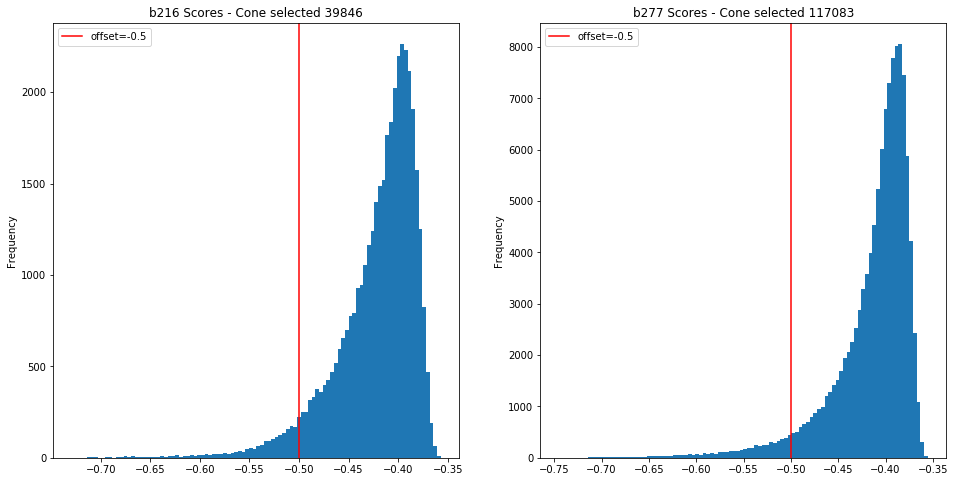

In [30]:
def plot_hist(tn, ax):
    cone, clf, scone = cones[tn], trees[tn], scones[tn]
    cone.score.plot.hist(ax=ax, label="_nolabel_", bins=100)
    ax.axvline(clf.offset_, color="r", label=f"offset={clf.offset_}")
    
    cmean, std = cone.score.median(), cone.score.std() 
    
    ax.set_title(f"{tn} Scores - Cone selected {len(cone)}")
    ax.legend()
    

fig, axes = plt.subplots(1, 2, figsize=(16, 8))

plot_hist("b216", axes[0])
plot_hist("b277", axes[1])

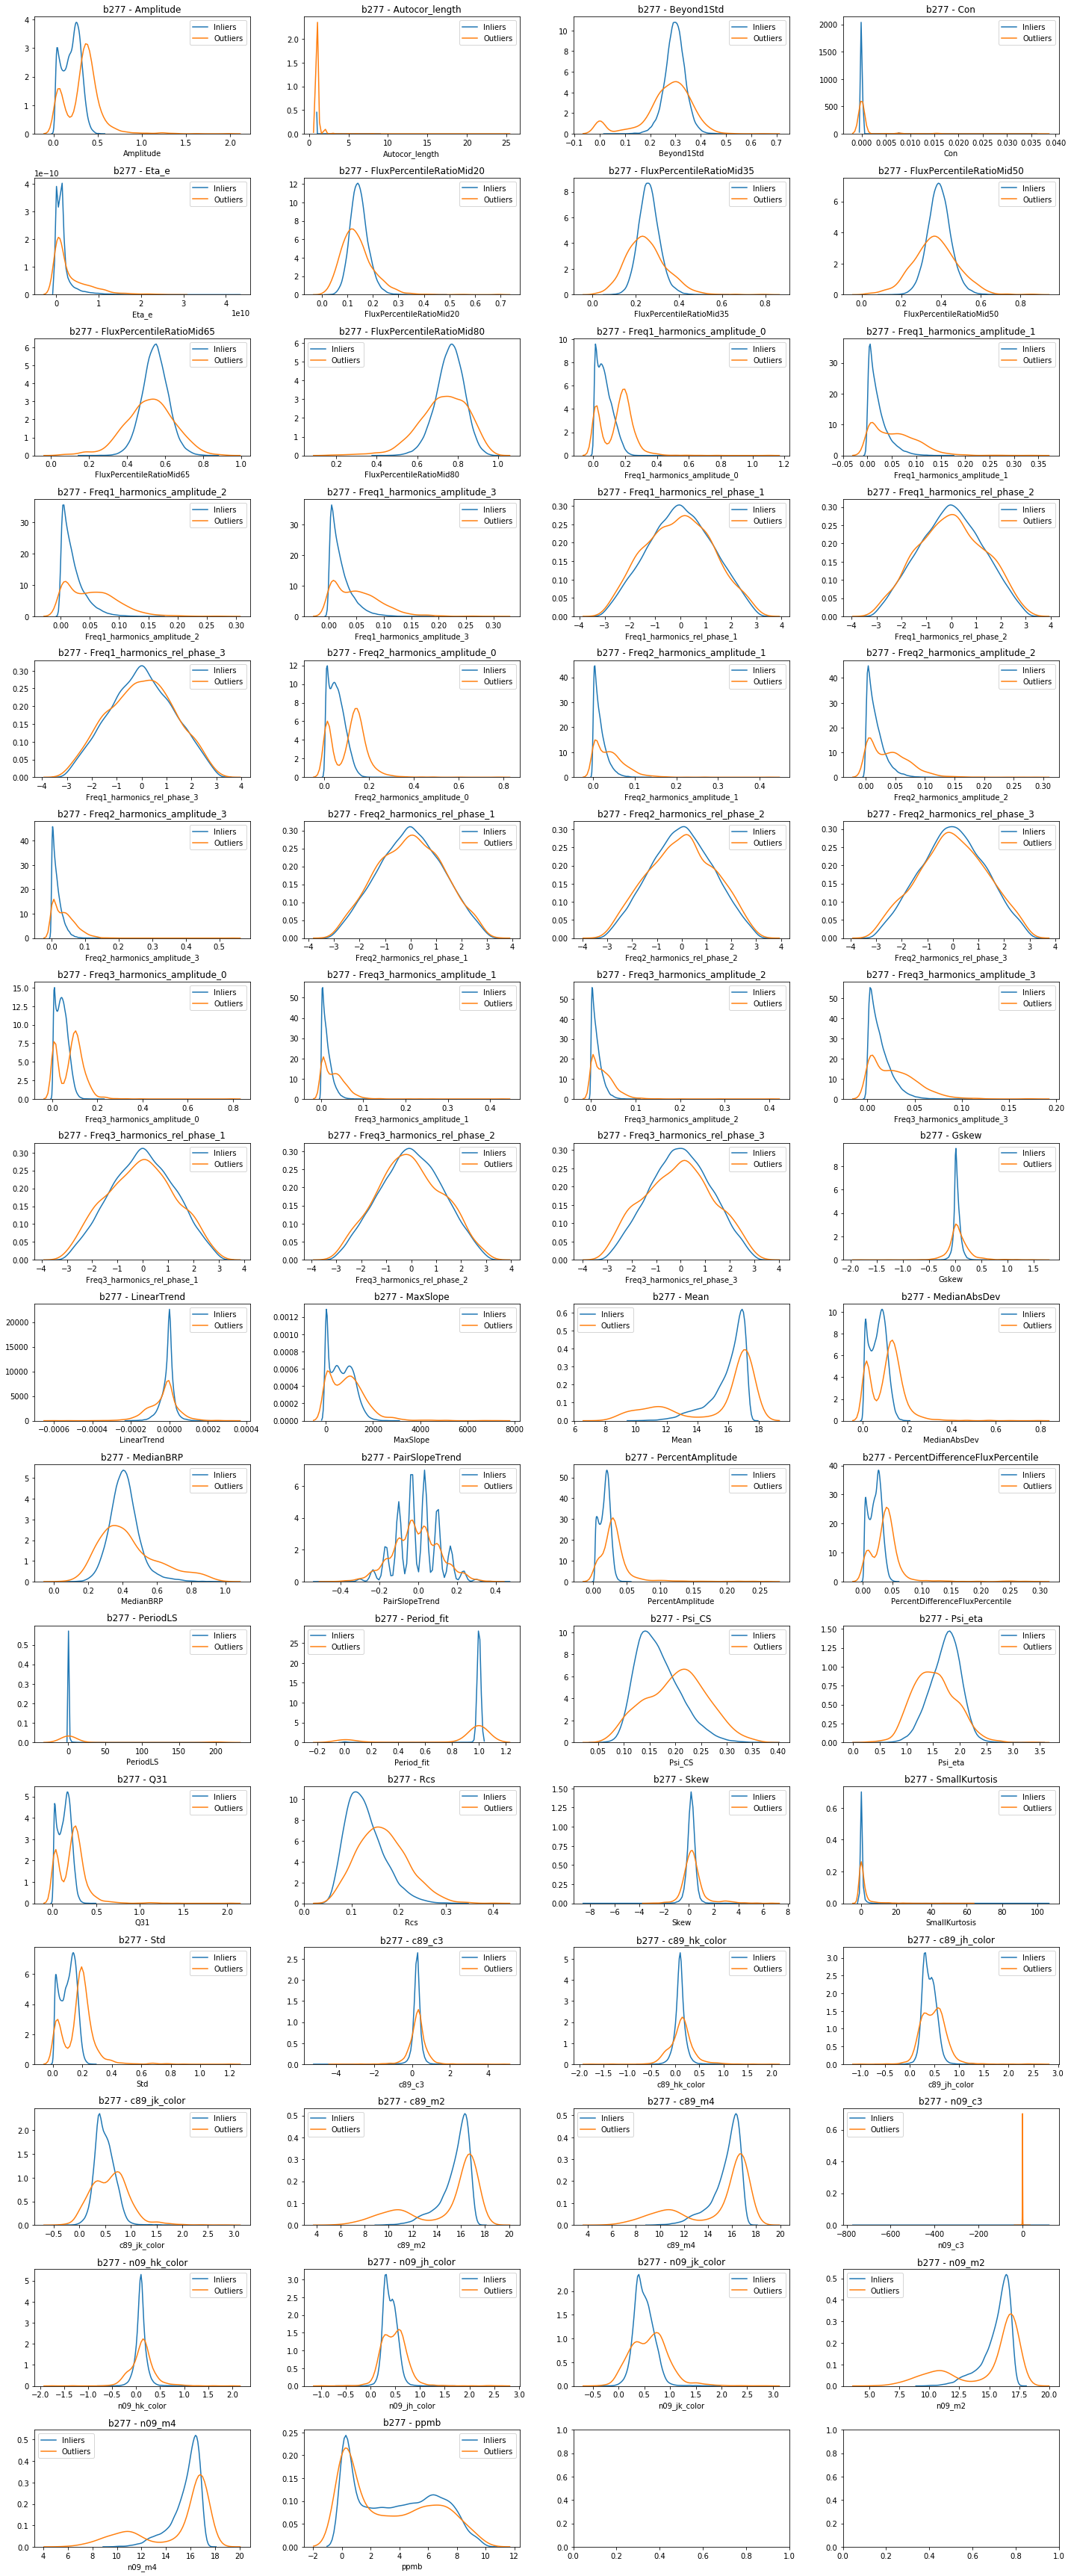

In [51]:
def plot_feats(tname, axes):    
    cone = cones[tname]
    
    axes = it.chain(*axes)
    
    ins = cone[cone.score >= -0.5] 
    outs = cone[cone.score < -0.5]

    for feat, ax in zip(FEATURES, axes):
        sns.distplot(ins[feat], ax=ax, label="Inliers", hist=False)
        sns.distplot(outs[feat], ax=ax, label="Outliers", hist=False)
        ax.set_title(f"{k} - {feat}")

    ax.legend()
    
    

fig, axes = plt.subplots(16, 4, figsize=(4 * 5, 3 * 16))
plot_feats("b216", axes)
fig.tight_layout()

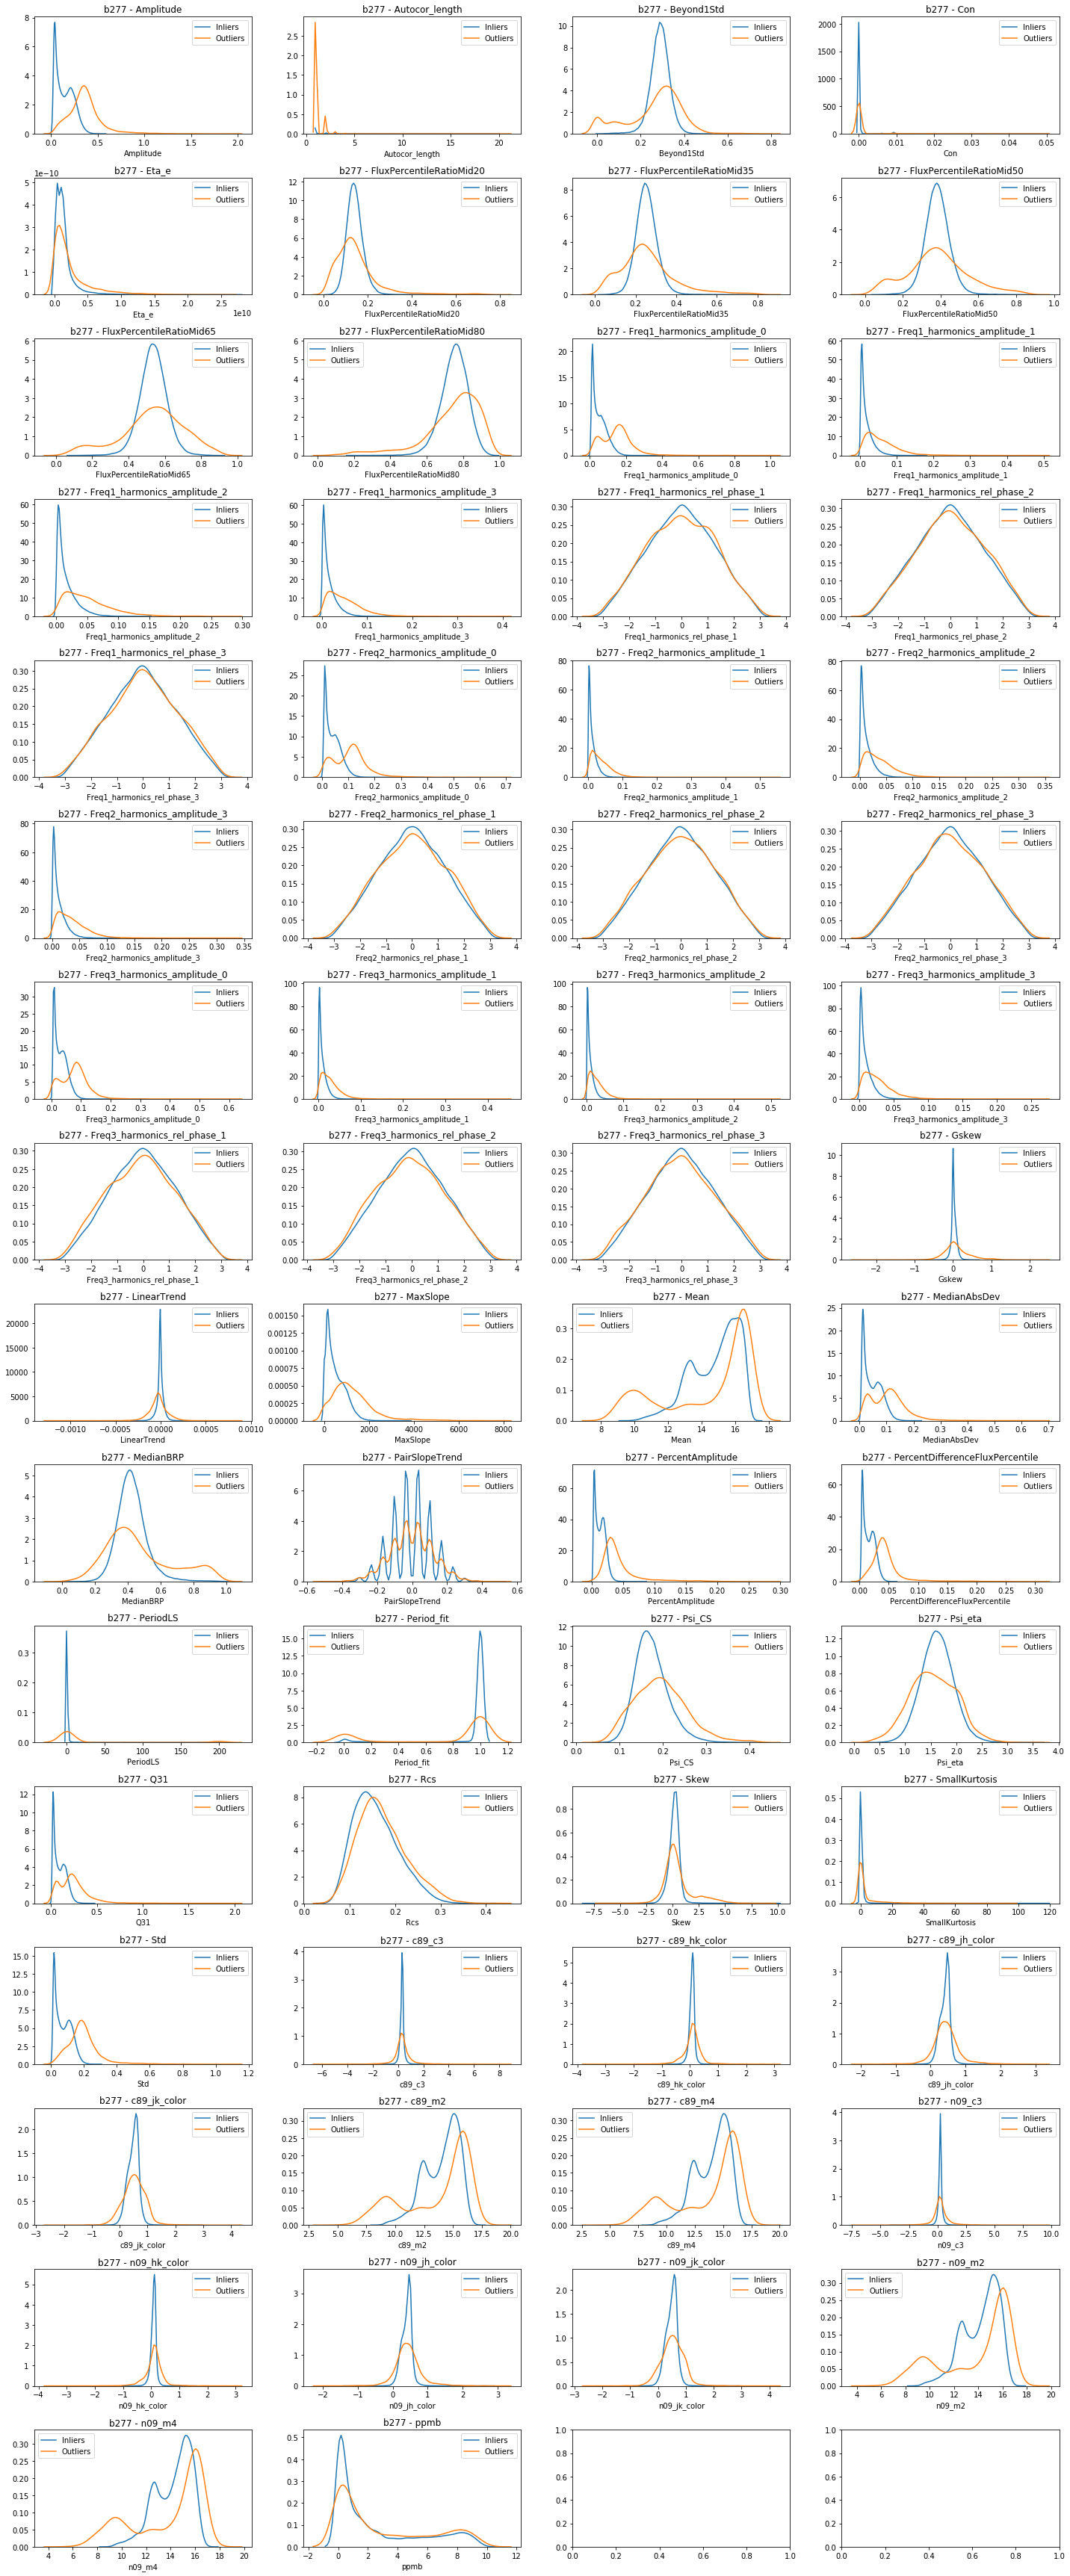

In [52]:
fig, axes = plt.subplots(16, 4, figsize=(4 * 5, 3 * 16))
plot_feats("b277", axes)
fig.tight_layout()